# Precision Oncology: Genomic Drug Sensitivity Prediction

# Modeling

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.dummy import DummyRegressor

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

# evaluation metrics / interpretability
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
import shap

In [2]:
# import datasets
df_train = pd.read_csv("data/train_scaffold_split.csv", low_memory=False)
df_test = pd.read_csv("data/test_scaffold_split.csv", low_memory=False)

for df in [df_train, df_test]:
    df['scaffold'] = df['scaffold'].astype(str).replace('nan', 'Unknown')

In [3]:
# define feature sets
target = 'pic50'

ic50_columns = ['ic50', 'molar_conc_uM', 'molar_conc_M']
excluded_columns = ['smiles', 'scaffold', 'cell_line_name', 'drug_name', 'auc', 'z_score',
                   'rmse', 'max_conc', 'drug_id', 'cosmic_id'] + ic50_columns + [target]

features = [c for c in df_train.columns if c not in excluded_columns]

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

features = X_train.columns.tolist()

print(f"Training on {X_train.shape[0]} samples with {len(features)} features.")
print(f"Target variable set to {target}.")

Training on 159752 samples with 1759 features.
Target variable set to pic50.


In [4]:
# model evaluation function
def evaluate_drug_model(y_true, y_pred, title="Model Performance"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    pearson, _ = pearsonr(y_true, y_pred)
    spearman, _ = spearmanr(y_true, y_pred)

    print(f"---{title}---")
    print(f"RMSE: {rmse:.4f}")
    print(f"Pearson Correlation: {pearson:.4f}")
    print(f"Spearman Correlation: {spearman:.4f}")

    plt.figure(figsize=(4,4))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('Actual pIC50')
    plt.ylabel('Predicted pIC50')
    plt.show()

Baseline (Mean) Dummy Prediction: 
---Dummy (Mean) Baseline Test---
RMSE: 1.1957
Pearson Correlation: nan
Spearman Correlation: nan


C:\Users\pkkjr\AppData\Local\Temp\ipykernel_29628\1578797743.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson, _ = pearsonr(y_true, y_pred)
C:\Users\pkkjr\AppData\Local\Temp\ipykernel_29628\1578797743.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, _ = spearmanr(y_true, y_pred)


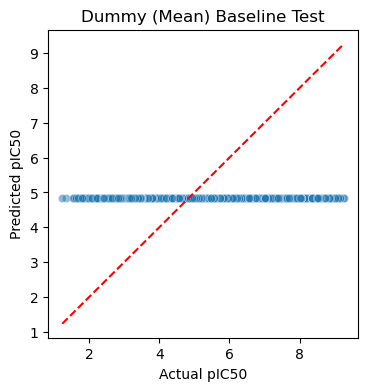

In [5]:
# dummy regressor (predict the mean)
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

dummy_preds = dummy.predict(X_test)

print("Baseline (Mean) Dummy Prediction: ")
evaluate_drug_model(y_test, dummy_preds, title="Dummy (Mean) Baseline Test")

---Ridge (Train)---
RMSE: 0.5568
Pearson Correlation: 0.8942
Spearman Correlation: 0.8580


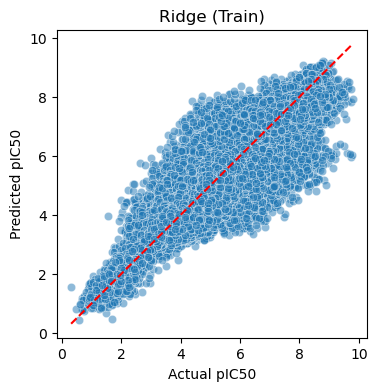

---Ridge (Scaffold Test)---
RMSE: 1.1764
Pearson Correlation: 0.3938
Spearman Correlation: 0.2731


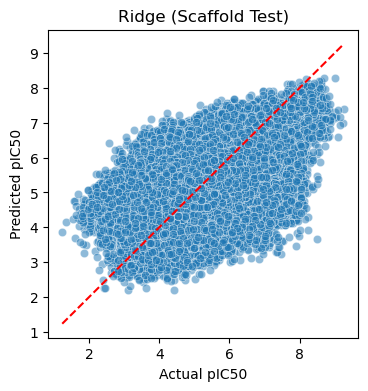

In [6]:
# basic model (ridge)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

train_preds = ridge_model.predict(X_train)
test_preds = ridge_model.predict(X_test)

evaluate_drug_model(y_train, train_preds, title="Ridge (Train)")
evaluate_drug_model(y_test, test_preds, title="Ridge (Scaffold Test)")

---Random Forest (Train)---
RMSE: 0.2302
Pearson Correlation: 0.9840
Spearman Correlation: 0.9800


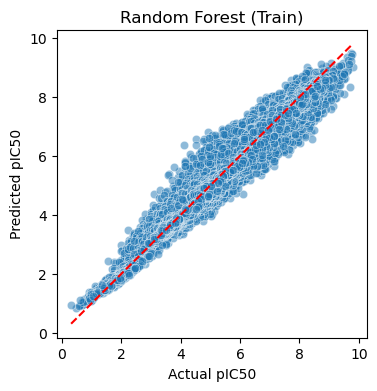

---Random Forest (Scaffold Test)---
RMSE: 1.2225
Pearson Correlation: 0.2895
Spearman Correlation: 0.2630


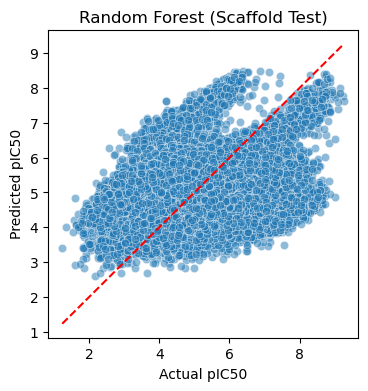

In [7]:
# basic model (rf)
rfr_model = RandomForestRegressor(n_jobs=-1)
rfr_model.fit(X_train, y_train)

train_preds = rfr_model.predict(X_train)
test_preds = rfr_model.predict(X_test)

evaluate_drug_model(y_train, train_preds, title="Random Forest (Train)")
evaluate_drug_model(y_test, test_preds, title="Random Forest (Scaffold Test)")

---XGBoost (Train)---
RMSE: 0.5113
Pearson Correlation: 0.9125
Spearman Correlation: 0.8806


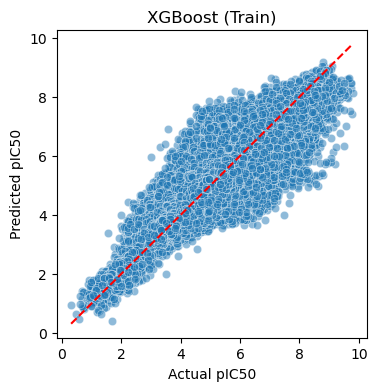

---XGBoost (Scaffold Test)---
RMSE: 1.1430
Pearson Correlation: 0.4145
Spearman Correlation: 0.3622


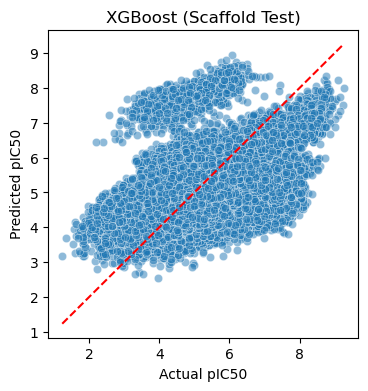

In [8]:
# advanced model (xgboost)
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

evaluate_drug_model(y_train, train_preds, title="XGBoost (Train)")
evaluate_drug_model(y_test, test_preds, title="XGBoost (Scaffold Test)")

In [11]:
# hyperparameter tuning

X_train_opt, X_val, y_train_opt, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_jobs': -1,
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X_train_opt, y_train_opt)
    preds = model.predict(X_val)
    error = mean_squared_error(y_val, preds, squared=False)
    return error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
xgb_model_tuned = XGBRegressor(**study.best_params)
xgb_model_tuned.fit(X_train, y_train)

[I 2025-12-29 11:20:48,679] A new study created in memory with name: no-name-70e612af-b13f-4578-bab9-43fe1b41fd5e
C:\Users\pkkjr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-12-29 11:21:26,513] Trial 0 finished with value: 0.6295153127546409 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.13860257821321942}. Best is trial 0 with value: 0.6295153127546409.
C:\Users\pkkjr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-12-29 11:25:04,254] Trial 1 finished with value: 0.50482676111239 and parameters: {'n_estimators': 874, 'max_depth': 10, 'learning_rate

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.12240585640205293, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=912, n_jobs=None,
             num_parallel_tree=None, ...)

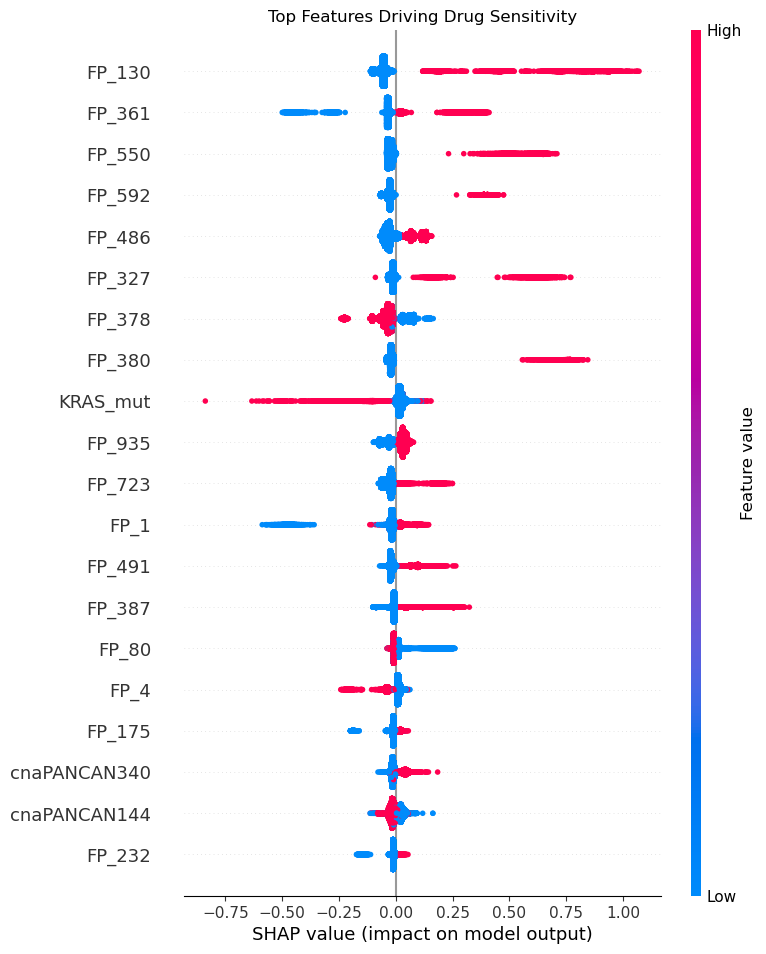

In [12]:
# model evaluation (SHAP)

shap.initjs()

explainer = shap.TreeExplainer(xgb_model_tuned)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(6,6))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('Top Features Driving Drug Sensitivity')
plt.show()

In [13]:
# error analysis
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_preds,
    'Error': np.abs(y_test - test_preds)
})

worst_predictions = results.sort_values(by='Error', ascending=False).head(5)
print("Top 5 Worst Predictions (Potential Activity Cliffs)")
display(worst_predictions)

Top 5 Worst Predictions (Potential Activity Cliffs)


,Actual,Predicted,Error
9480,2.563102,7.226984,4.663882
10027,3.092159,7.689179,4.597020
9912,2.899139,7.353377,4.454238
10198,3.283498,7.705320,4.421822
9568,3.428465,7.817281,4.388816


In [15]:
# save model
filename = "xgb_model_tuned.joblib"
joblib.dump(xgb_model_tuned, f"models/{filename}")

['models/xgb_model_tuned.joblib']